<a href="https://colab.research.google.com/github/MotoBenny/Hands-on-ML/blob/main/Chapter3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3: Classification

Working with the MNIST dataset to classify handwritten digits. 

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False) # using the fetch openml function bundled with sklearn to download this very common dataset.
# as this dataset contains images, we dont want it to import as a pandas dataframe. hence as_frame=False
# instead we receive the data as NumPy arrays

# other functions of this tool include:
# load() to load small toy datasets bundled with sklearn
# make() to generate datasets, useful for testing. 

In [2]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [3]:
X.shape

(70000, 784)

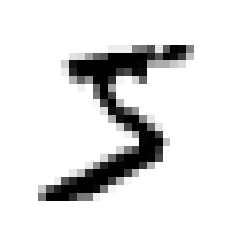

In [8]:
# lets look at a single image from our dataset.

import matplotlib.pyplot as plt

def plot_digit(image_data):
  image = image_data.reshape(28,28) # reshaping to a 28x28 array so we can use imshow to display it. 
  plt.imshow(image, cmap="binary") # cmap gets us a greyscale color map where 0 is white and 255 is black
  plt.axis("off")

some_digit = X[0] # change this number here from 0 to 69999 to see a specific instance feature
plot_digit(some_digit)
plt.show()

In [9]:
y[0] # our X value for each feature instance is the image itself, or rather its vector.
# where our y value is the label within the dataset, here we can see that this first digit is a 5

'5'

# Test set

This dataset is already split for us, with a test set comprised of the last 10K images.

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Identifying a single digit, Binary Classifier.


In [13]:
y_train_5= (y_train == '5') # return True for all 5s False for any other digit. 
y_test_5 = (y_test == '5')

## Picking a classifier and training it.

Starting with a stochastic gradient decent with the built in sklearn class.
These classifiers are greate with very large datasets. 

In [14]:
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(random_state=42) # assigning the classifier with our random seed.
sgd_clf.fit(X_train,y_train_5) # fitting

SGDClassifier(random_state=42)

In [16]:
# now we can use the model to detect the number 5
sgd_clf.predict([some_digit])

array([ True])

# Evaluating the classifyier.

This is generally significantly harder than evaluating a regressor model. 
lets try cross-validation

In [17]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") 

array([0.95035, 0.96035, 0.9604 ])

In [18]:
# how about the dummyclassifier?

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [19]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

Great! we are getting over 90% accuracy. But its only because only 10% of the images are actually 5s, so our model will always guess that an image is not a 5, and its right about 90% of the time. This wont do, but perfectly demonstrates that when dealing with classifiers accuracy is not the preferred performance measure. 

A much better way to evaluate the performance of a classifier is with a confusion matrix.

# Confusion Matrices

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # cv here specifies the number of folds we want to perform.

In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

# understanding the matrix

each row represents an actual class, while each column is a predicted class. in this case 53,892 images were correctly classified as "not 5", while the remaining 687 were wrongly classified as 5s (false-positives).

Lets look at some metrics for our classifier, using built in sklearn functions. 

In [22]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [23]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

this is a much clearer view of the performance of the classifier right now. 
83.7% of the time it correctly classifies a 5. but its only detecting 65.1% of all 5s in the set. 

Lets generallize these scores together into a F1 score, using a harmonic mean (which give more weight to low scores)

In [24]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

# Precision/recall trade-off

You often want to tune your classification model for either or, But you cannot have both. 

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
threshold = 3000 # here we can set the desicion threshold
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How do we decide what to set out threshold too?

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [31]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Now lets ploit our our precision and recall with matplotlib.

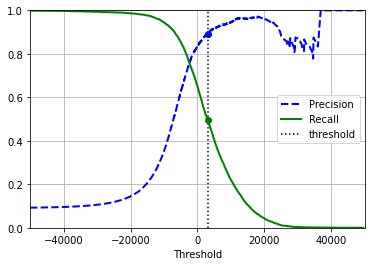

In [34]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

At this threshold we can see precision is near 90% and recall is around 50%.

Below we plot precision directly against recall.

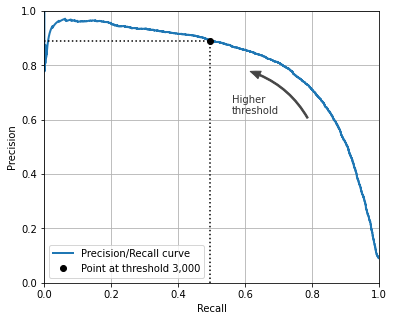

In [35]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

lets suppose we decided to bias for precision, and we want 90%. Lets use numpy argmax() function to search for the lowest threshold that gives us at least 90%

In [36]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557